In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import skimage.io as skio

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("Input"))

['olivetti_faces.npy', 'olivetti_faces_target.npy']


In [39]:
def load_train_test_set():
    faces  = np.load('Input/olivetti_faces.npy')
    target = np.load('Input/olivetti_faces_target.npy')
    
    print("Original faces.shape:"+ str(faces.shape))
    print("Original target.shape:"+ str(target.shape))
    
    # create a test set that takes one face for each person
    test_index = list(range(9,400,10))
    faces_test = faces[test_index]
    target_test = target[test_index]
    
    # preprare training set by removing items in test set
    faces_train = faces.copy()
    target_train =  target.copy()
    for i in test_index[::-1]:
        faces_train  = np.delete(faces_train,i,axis =0 )
        target_train = np.delete(target_train,i,axis =0 )
    
    print("faces_train.shape:" +str(faces_train.shape)) 
    print("target_train.shape:" +str(target_train.shape))
    print("faces_test.shape:" +str(faces_test.shape)) 
    print("target_test.shape:" +str(target_test.shape))
    return faces_train, target_train, faces_test, target_test

In [40]:
faces_train, target_train, faces_test, target_test = load_train_test_set()

Original faces.shape:(400, 64, 64)
Original target.shape:(400,)
faces_train.shape:(360, 64, 64)
target_train.shape:(360,)
faces_test.shape:(40, 64, 64)
target_test.shape:(40,)


In [41]:
def show_sample_training_and_test_images(faces_train, faces_test):
    fig = plt.figure()
    fig.add_subplot(1, 4, 1)
    plt.imshow(faces_train[0], cmap='gray')
    fig.add_subplot(1, 4, 2)
    plt.imshow(faces_train[1], cmap='gray')
    fig.add_subplot(1, 4, 3)
    plt.imshow(faces_train[9], cmap='gray')
    fig.add_subplot(1, 4, 4)
    plt.imshow(faces_train[10], cmap='gray')
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(faces_test[0], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(faces_test[1], cmap='gray')

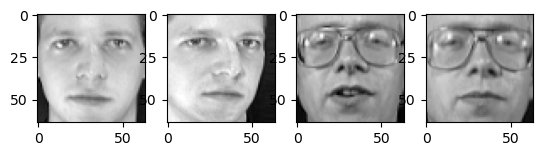

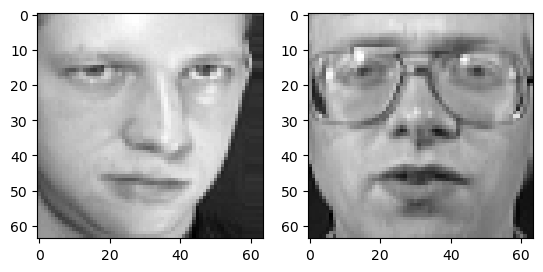

In [42]:
show_sample_training_and_test_images(faces_train, faces_test)

In [43]:
def preprocess_data( faces_train, faces_test ):
    # flatten the imagaes from 
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.mean(X_train, axis = 0)
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set 
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test  

In [44]:
X_train, X_test = preprocess_data(faces_train, faces_test )
print("X_train.shape=" + str(X_train.shape))
print("X_test.shape="  + str(X_test.shape))

X_train.shape=(360, 4096)
X_test.shape=(40, 4096)


In [45]:
class PCA:
    def __init__( self, optimize = False ):
        self.__optimize = optimize
        
    def __calculate_covariance_matrix( self, X ):
        if self.__optimize:
            return X @ X.T
        else:
            return X.T @ X

    def __get_eigenvecs_sorted_by_eigenvals( self, S ):
        w, v = np.linalg.eig(S)
        sorted_index = np.argsort(w)[::-1]
        eigenvals = w[sorted_index]
        eigenvecs = v[:,sorted_index]
        return eigenvals, eigenvecs

    def __get_eigenvec_for_original_matrix(  self, X, eigenvecs ):
        U = X.T @ eigenvecs
        return U

    def fit( self, X ):
        S = self.__calculate_covariance_matrix( X )
        eigenvals,eigenvecs =   self.__get_eigenvecs_sorted_by_eigenvals( S )
        if self.__optimize :
            B = self.__get_eigenvec_for_original_matrix(X, eigenvecs )
        else:
            B = eigenvecs
            
        self.__B = B
        self.__w = eigenvals
        return B
        
    def plot_eigenvals ( self ):
        c = np.cumsum ( self.__w )
        plt.plot( c )
        
    def get_num_components ( self, variance_threshold):
        variance_ratio = self.__w/np.sum(self.__w)
        s = 0
        i = -1
        while s < variance_threshold and s < 1.0:
            i += 1
            s +=  variance_ratio[i]
            
        return i

In [46]:
def show_images( images, num_images_to_show ):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = np.reshape( images[:,i-1], (64,64) )
        plt.imshow(img, cmap='gray')

64


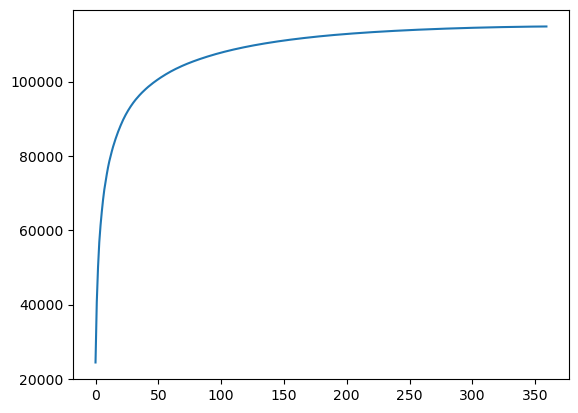

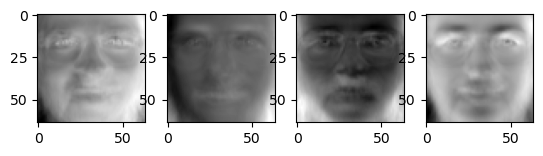

In [47]:
pca = PCA( optimize = True )
B = pca.fit(X_train)
pca.plot_eigenvals()
num_dim = pca.get_num_components(0.9)
print( num_dim )
B = B[:,:num_dim]
# show top 4 eigenfaces
show_images( B, 4 )

In [48]:
class Projection:
    def __init__( self, B ):
        self.B = B
        
    def reduce_dim( self, X ):
        return  X @ B @ np.linalg.inv(B.T @ B)  

    def reconstruct( self, X_reduced ):
        return X_reduced @ B.T
    
    def get_projection_matrix( self ):
        P = B @ np.linalg.inv(B.T @ B) @ B.T
        return P
    
    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P

X_train_reduced.shape=(360, 64)


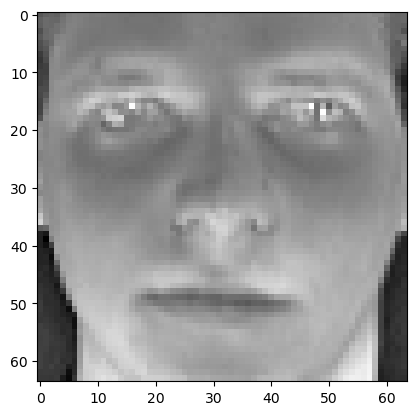

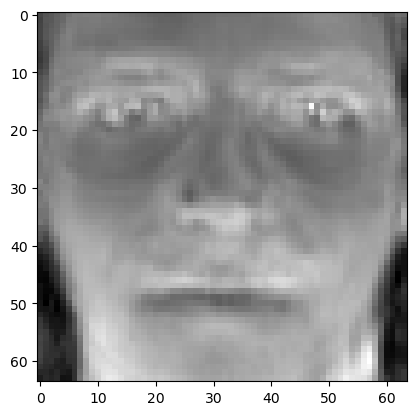

In [49]:
class Projection:
    def __init__( self, B ):
        self.B = B
        
    def reduce_dim( self, X ):
        return  X @ B @ np.linalg.inv(B.T @ B)  

    def reconstruct( self, X_reduced ):
        return X_reduced @ B.T
    
    def get_projection_matrix( self ):
        P = B @ np.linalg.inv(B.T @ B) @ B.T
        return P
    
    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P
proj = Projection( B )
X_train_reduced = proj.reduce_dim(X_train )
print("X_train_reduced.shape="+str(X_train_reduced.shape) )
show_images(X_train.T, 1)
r_img = proj.reconstruct( X_train_reduced[0,:])
r_img = np.reshape(r_img,(4096,1))
show_images(r_img, 1)


In [50]:
X_test_reduced =proj.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced.shape) )

X_test_reduced.shape=(40, 64)


In [51]:
class ImageClassifier:
    def __init__( self, class_count ):
        self.class_count = class_count
        
    def __get_class_mean( self, X, target ):
        class_count = self.class_count
        N,D = X.shape
        mu = np.zeros((class_count,D))
        for i in range(class_count):
            mu[i,:] = (1/N) * np.sum(X[target == i,: ], axis = 0 )
        return mu 

    def __dist(self, v1, v2 ):
        diff = v1-v2
        d = np.sqrt(np.dot(diff,diff))
        return d
    def fit( self,  X, target  ):
        class_count = self.class_count
        mu = self.__get_class_mean( X, target )
        self.mu = mu
        
    def predict( self, test_img ):
        min_dist = float('inf')
        min_class = -1
        for i in range( self.class_count ):
            d = self.__dist(test_img, self.mu[i,:])
            if d < min_dist:
                min_dist = d
                min_class = i
            
        return min_class, self.mu[min_class,:]

In [52]:
print("X_test_reduced.shape=" + str(X_test_reduced.shape))
print("X_train_reduced.shape=" + str(X_train_reduced.shape))
img_classifer = ImageClassifier(40)   
img_classifer.fit(X_train_reduced,target_train )
recognized_class, mu_rec = img_classifer.predict( X_test_reduced[5,:])
print("recognized_class="+ str(recognized_class))

X_test_reduced.shape=(40, 64)
X_train_reduced.shape=(360, 64)
recognized_class=5


In [53]:
def get_half_image( test_image_index ):
    orig_image = np.copy(X_test[test_image_index,:])
    D, = orig_image.shape
    orig_image = np.reshape(orig_image, (1,D) )
    # blacken lower half of the face
    
    half_image = np.copy(orig_image)
    half_image[0, 2048: 4096] = 0
    return half_image, orig_image

In [54]:
def reconstruct_half_images( test_indexes ):
    for i in test_indexes:
        half_image, orig_image = get_half_image(i)
        N,D = half_image.shape
        new_image = proj.project( half_image  )
        #target, mu_rec = recognize_image( reduced_half_image[0,: ], X_train_reduced, target_train  )
        #print(target)
        #new_image = reconstruct_image( reduced_half_image, B )
        new_image[0,0:2048,] = orig_image[0, 0:2048]
        images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T), axis=1 )
        show_images(images_for_display, 3)

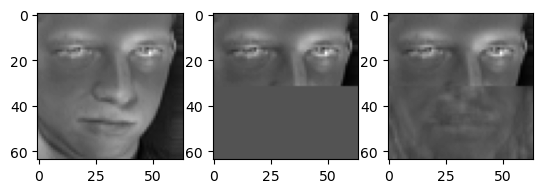

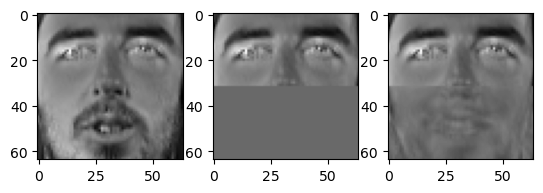

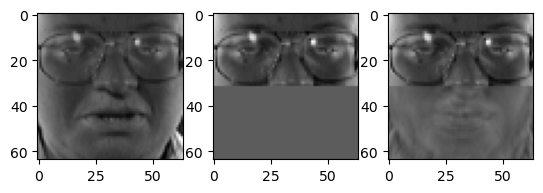

In [55]:
reconstruct_half_images([0,10,30])